In [1]:
import pandas as pd, yaml
from fmcml.data import load_data, load_splitter
import matplotlib.pyplot as plt
import xarray as xr

In [2]:
config = "../config/nn.yml"
with open(config) as cf:
    conf = yaml.load(cf, Loader=yaml.FullLoader)

In [ ]:
seed = conf["seed"]
verbose = conf["verbose"]

save_loc = conf["save_loc"]
data_loc = conf["data_loc"]
input_vars = conf["input_vars"]
static_vars = conf["static_vars"]
output_vars = conf["output_vars"]
verbose = conf["verbose"]
total_input_vars = input_vars + static_vars

# model config
input_size = len(total_input_vars)
middle_size = conf["model"]["middle_size"] 
output_size = len(output_vars)
dropout = conf["model"]["dropout"]
num_layers = conf["model"]["num_layers"]
#optimzer config
learning_rate = conf["optimizer"]["learning_rate"]
L2_penalty = conf["optimizer"]["L2_penalty"]
# trainer config
n_splits = conf["trainer"]["n_splits"]
batch_size = conf["trainer"]["batch_size"]
valid_batch_size = conf["trainer"]["valid_batch_size"]
lr_patience = conf["trainer"]["lr_patience"]
stopping_patience = conf["trainer"]["stopping_patience"]
epochs = conf["trainer"]["epochs"]
batches_per_epoch = conf["trainer"]["batches_per_epoch"]
training_loss = conf["trainer"]["training_loss"]
metric = conf["trainer"]["metric"]

### Load the data frame with filtered columns 

In [5]:
df = load_data(
    data_loc,
    verbose = True,
    filter_input_vars = total_input_vars, 
    filter_output_vars = output_vars
)

In [6]:
df.shape

(513120, 60)

### Split the data by d-m-y

In [7]:
splitter = "day"

In [12]:
data_folds_day = load_splitter(
    splitter,
    df, 
    n_splits = n_splits,
    seed = seed,
    columns = ["day"]
)

In [13]:
for train, valid, test in data_folds_day:
    print(train.shape, valid.shape, test.shape)
    break

(402797, 61) (56159, 61) (54164, 61)


Text(0.5, 0, 'FMC value')

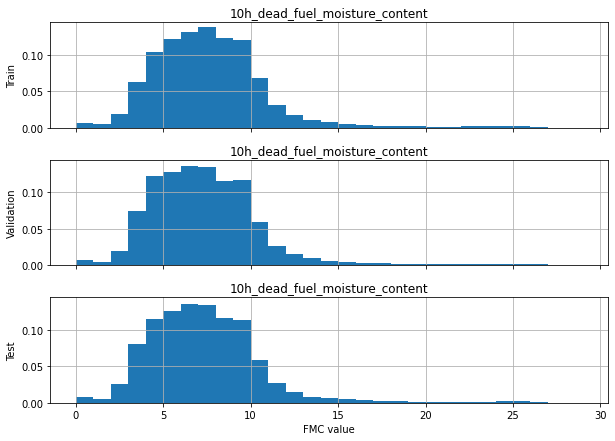

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 7), sharex=True, sharey='col')

train[output_vars].hist(ax = ax1, bins = range(30), density = True)
valid[output_vars].hist(ax = ax2, bins = range(30), density = True)
test[output_vars].hist(ax = ax3, bins = range(30), density = True)

ax1.set_ylabel("Train")
ax2.set_ylabel("Validation")
ax3.set_ylabel("Test")
ax3.set_xlabel("FMC value")

### Split the data by random shuffle 

In [15]:
splitter = "random"

In [16]:
data_folds_random = load_splitter(
    splitter,
    df, 
    n_splits = n_splits, 
    seed = seed
)

In [17]:
for train, valid, test in data_folds_random:
    print(train.shape, valid.shape, test.shape)
    break

(408700, 61) (53108, 61) (51312, 61)


Text(0.5, 0, 'FMC value')

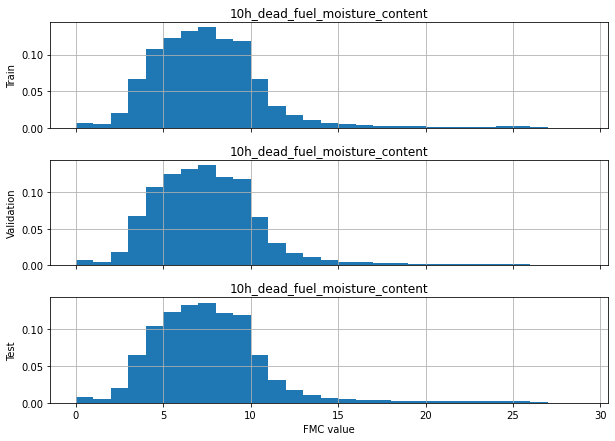

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 7), sharex=True, sharey='col')

train[output_vars].hist(ax = ax1, bins = range(30), density = True)
valid[output_vars].hist(ax = ax2, bins = range(30), density = True)
test[output_vars].hist(ax = ax3, bins = range(30), density = True)

ax1.set_ylabel("Train")
ax2.set_ylabel("Validation")
ax3.set_ylabel("Test")
ax3.set_xlabel("FMC value")

### Splitting by site

In [23]:
splitter = "random-spatial"

In [24]:
random_spatial_splitter = load_splitter(
    splitter,
    df, 
    n_splits = n_splits, 
    seed = seed
)

In [25]:
import geopandas as gpd

def plot_site_splits_df(train_set, valid_set, test_set, var_name):
    """
    Plots a variable with n_sites as a dimension from a training set, validation set, and test set
    """
    fig, (ax0,ax1,ax2) = plt.subplots(3,1,figsize = (12,9))
    fig.tight_layout()
    train_gdf = gpd.GeoDataFrame(train_set[var_name], geometry=gpd.points_from_xy(train_set["longitude"],train_set["latitude"]))
    valid_gdf = gpd.GeoDataFrame(valid_set[var_name], geometry=gpd.points_from_xy(valid_set["longitude"],valid_set["latitude"]))
    test_gdf = gpd.GeoDataFrame(test_set[var_name], geometry=gpd.points_from_xy(test_set["longitude"],test_set["latitude"]))
    train_gdf.plot(column = var_name, cmap = 'rainbow',
                legend = True, legend_kwds={'shrink': 0.3}, 
                markersize = 10, ax=ax0)
    ax0.set_title("Training Set")
    valid_gdf.plot(column = var_name, cmap = 'rainbow',
                legend = True, legend_kwds={'shrink': 0.3}, 
                markersize = 10, ax=ax1)
    ax1.set_title("Validation Set")
    test_gdf.plot(column = var_name, cmap = 'rainbow',
                legend = True, legend_kwds={'shrink': 0.3}, 
                markersize = 10,ax=ax2) 
    ax2.set_title("Test Set")
    plt.show()

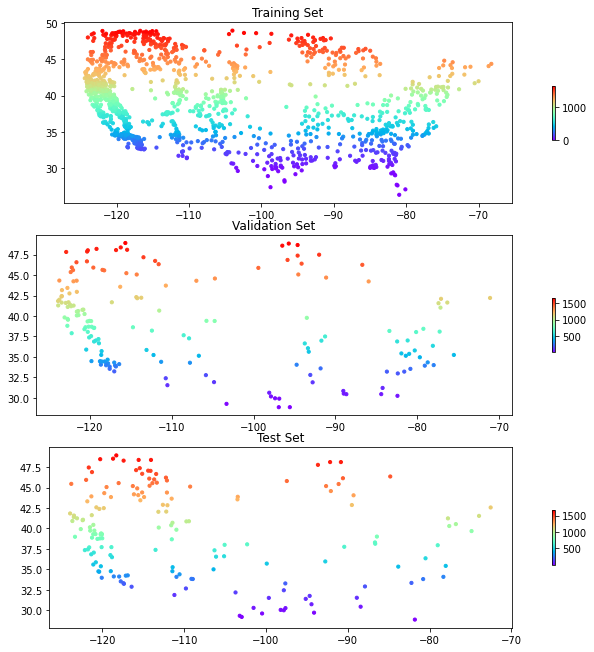

(403717, 62) (57852, 62) (51551, 62)


In [26]:
for (train, valid, test) in random_spatial_splitter:
    plot_site_splits_df(
        train[['labels','latitude','longitude']].drop_duplicates(),
        valid[['labels','latitude','longitude']].drop_duplicates(),
        test[['labels','latitude','longitude']].drop_duplicates(),
        "labels"
    )
    print(train.shape, valid.shape, test.shape)
    break